### ENEL 645 Winter 2024 Assignment 2
**Group 11: Henry Zhao, Israel Robels, Paolo Geronimo, Jon Fulford, Carrie Chan**

March 8, 2024

In this assignment, we aim to construct and evaluate a multi-class classification deep learning model. This model's primary objective is to accurately categorize images of waste materials into one of the following discrete categories: Green Bin, Blue Bin, Black Bin, or an alternative classification, designated as 'Other'.

**Dependencies:**

PyTorch will be used for this assignment.

In [23]:
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

import gc

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
# Determine Training Device - ideally using GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
print("Memory Allocated:", torch.cuda.memory_allocated()) # Should be 0 before we begin

Using device: cuda:0
Memory Allocated: 0


**Load Data:**

A local GPU (not TALC) was used for this assignment. We first clear the current GPU to free up memory for a new session.

In [3]:
# Clear any cached memory and collect garbage
torch.cuda.empty_cache()
gc.collect()

# Check memory - should be 0 if everything was cleared
print("Memory Allocated:", torch.cuda.memory_allocated())  

Memory Allocated: 0



The data was downloaded from TALC and organized as shown in the figure below. This notebook is on the same directory level as the 'data' folder.

![imagefolders](./assets/imagefolders.png)

Implementing the data transformers for train and validation. Implementing data loaders for all sets:

In [4]:
# The transformations are used to augment the training data and to remove overfitting to scale and aspect ratio:
# Randomly crop a portion of the image, then resize to 224x224
# Randomly horizontally flip the image (defaulting to 50% chance)
# Normalize the images based on ImageNet dataset (mean and std dev values for RGB)
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
])

# These transforms ensure training and input image sizes are consistent.
# Resize to 256x256 first, then crop to 224x224
# Normalize the images based on ImageNet dataset (mean and std dev values for RGB)
validation_test_transforms = transforms.Compose([
    transforms.Resize(256), 
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load the datasets and transform
train_dataset = datasets.ImageFolder('data/Train', transform=train_transforms)
validation_dataset = datasets.ImageFolder('data/Validation', transform=validation_test_transforms)
test_dataset = datasets.ImageFolder('data/Test', transform=validation_test_transforms)

# Dataloaders
# Ideal num_workers found to be 12 to minimize wait between batch times to the GPU,
# without creating a bottleneck at the CPU
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=12)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=32, shuffle=True, num_workers=12)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=12)

print("Training Data Size:", len(train_dataset.samples))
print("Validation Data Size:", len(validation_dataset.samples))
print("Testing Data Size:", len(test_dataset.samples))

Training Data Size: 8000
Validation Data Size: 2000
Testing Data Size: 2000


**Visualize Training Data from Dataloader**

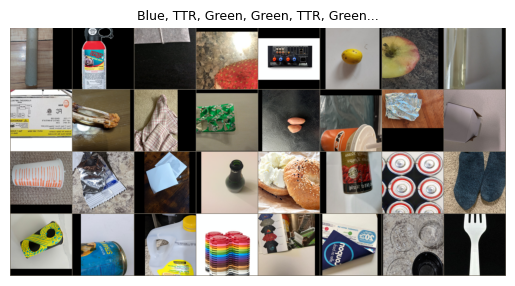

In [19]:
# The following code is adapted from pytorch.org: Beginner Transfer Learning Tutorial
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
# This code is used to quickly visualize the training data

def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))  # Convert tensor to numpy and change from CxHxW to HxWxC
    mean = np.array([0.485, 0.456, 0.406])  # Unnormalize using mean
    std = np.array([0.229, 0.224, 0.225])   # Unnormalize using std deviation
    inp = std * inp + mean                  # Apply unnormalization
    inp = np.clip(inp, 0, 1)  # Clip values to [0, 1] to prevent artifacts
    plt.imshow(inp)
    if title is not None:
        title = ', '.join(title[:6]) + ('...' if len(title) > 6 else '')  # Limit to first 6 labels
        plt.title(title, fontsize=9)  # You can adjust fontsize for better visibility
    plt.axis('off')
    plt.pause(0.001)  # pause to ensure plots update

# Get a batch of training data
inputs, classes = next(iter(train_loader))
class_names = ['Black', 'Blue', 'Green', 'TTR']

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

**Instantiate model using ResNet50**

ResNet 50 was used as the baseline model. The final layer of the model is replaced by a fully connected linear layer with 4 outputs, corresponding the the 4 labels we are looking for.

In [5]:
# Load the pre-trained model ResNet50, using default weights
model = models.resnet50(weights='ResNet50_Weights.DEFAULT')

# Freeze all the parameters in the model. We are not training the ResNet, just the final layer.
for param in model.parameters():
    param.requires_grad = False

# Replace the last fully connected layer with a Linear layer with 4 outputs
model.fc = nn.Linear(model.fc.in_features, 4)

# Move the model to the GPU
model = model.to(device)

print(model._get_name())
print("Memory Allocated:", torch.cuda.memory_allocated())

ResNet
Memory Allocated: 94312448


### Training the Model

**Transfer Learning Model using ResNet 50**

Final layer is replaced with a 4 output linear layer.

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters())

# Number of epochs
num_epochs = 25

# Path to save the model
model_save_path = './resnet_model/model_epoch_{}.pth'

print('Training ResNet - Transfer Learning - Final Layer replaced with 4 output Linear layer:')
for epoch in range(num_epochs):
    model.train() # Training mode
    
    running_loss = 0.0
    correct_predictions = 0

    for inputs, labels in train_loader:
        # Load inputs and lables
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Clear gradients before each backward pass to prevent accumulation
        optimizer.zero_grad()

        # Forward pass: compute predicted outputs by passing inputs through the model
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass:
        loss.backward() # Compute gradient of the loss with respect to model parameters
        optimizer.step() # Perform a single optimization step to update parameters

        # Set statistics to calculate loss:
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct_predictions += torch.sum(preds == labels.data)
    
    # Calculate loss:
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct_predictions.double() / len(train_loader.dataset)

    print(f'Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')
    
    # Validate and save model after every 5 epochs:
    if (epoch + 1) % 5 == 0:
        model.eval()  # Set model to evaluate mode
        validation_loss = 0.0
        correct_predictions = 0
        
        with torch.no_grad():
            for inputs, labels in validation_loader:
                # Load inputs and labels
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Get model output at current epoch
                outputs = model(inputs)
                # Get loss by using the predefined criterion
                loss = criterion(outputs, labels)
                
                # Set statistics to calculate loss
                validation_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct_predictions += torch.sum(preds == labels.data)
            
        # Calculate validation loss:
        val_loss = validation_loss / len(validation_loader.dataset)
        val_acc = correct_predictions.double() / len(validation_loader.dataset)
        
        print(f'Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}')
    
        # Save the model every 5 epochs
        torch.save(model.state_dict(), model_save_path.format(epoch+1))
        print(f'Model saved at {model_save_path.format(epoch+1)}')

# Save the final model
torch.save(model.state_dict(), model_save_path.format('final'))
print(f'ResNet Transfer Learning Model saved at {model_save_path.format("final")}')


Training ResNet - Transfer Learning - Final Layer replaced with 4 output Linear layer:
Epoch 1/25 - Loss: 0.7867, Accuracy: 0.6986
Epoch 2/25 - Loss: 0.6347, Accuracy: 0.7620
Epoch 3/25 - Loss: 0.5907, Accuracy: 0.7744
Epoch 4/25 - Loss: 0.5697, Accuracy: 0.7843
Epoch 5/25 - Loss: 0.5603, Accuracy: 0.7875
Validation Loss: 0.5694, Accuracy: 0.7810
Model saved at ./resnet_model/model_epoch_5.pth
Epoch 6/25 - Loss: 0.5320, Accuracy: 0.8023
Epoch 7/25 - Loss: 0.5337, Accuracy: 0.7935
Epoch 8/25 - Loss: 0.5269, Accuracy: 0.8030
Epoch 9/25 - Loss: 0.5126, Accuracy: 0.8046
Epoch 10/25 - Loss: 0.5099, Accuracy: 0.8066
Validation Loss: 0.5641, Accuracy: 0.7855
Model saved at ./resnet_model/model_epoch_10.pth
Epoch 11/25 - Loss: 0.4954, Accuracy: 0.8115
Epoch 12/25 - Loss: 0.5093, Accuracy: 0.8017
Epoch 13/25 - Loss: 0.5051, Accuracy: 0.8095
Epoch 14/25 - Loss: 0.4874, Accuracy: 0.8140
Epoch 15/25 - Loss: 0.4869, Accuracy: 0.8191
Validation Loss: 0.5598, Accuracy: 0.7795
Model saved at ./resnet_

From the cell above, training 25 epochs took 18 minutes and 39 seconds. This is **~45 seconds per epoch**, including validating the model every 5 epochs.

The list of epochs along with the loss and accuraccy of each epoch was recorded into a csv. The following is a plot:

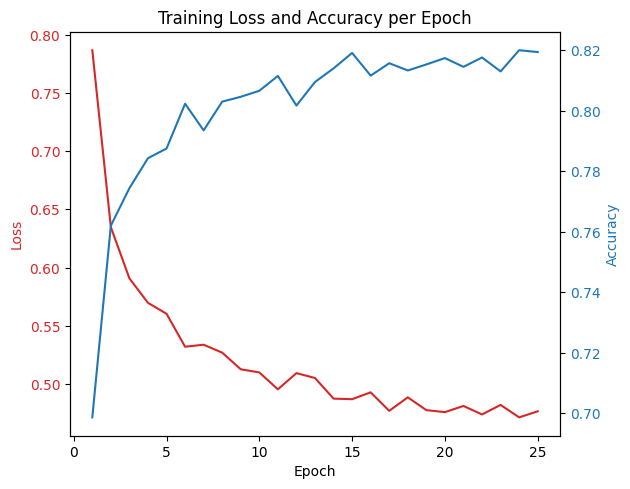

In [13]:
# Plot the loss and accuracy from the cell above as a function of Epoch number
results_data = pd.read_csv('./assets/training_results.csv')

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(results_data['Epoch'], results_data['Loss'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)  # we already handled the x-label with ax1
ax2.plot(results_data['Epoch'], results_data['Accuracy'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Training Loss and Accuracy per Epoch')
plt.show()


### Adjust Model Based on Validation Set Accuracies

**Retrain by Unfreezing some ResNet layers**

We see that validation accuracies have capped out at around 78%. Here we will unfreeze the final layer of ResNet to attempt to achieve a higher accuracy.

In [20]:
# Load the final model
model.load_state_dict(torch.load('./resnet_model/model_epoch_final.pth'))

for name, child in model.named_children():
    if name in ['layer4', 'fc']:  # Unfreeze the last block and the fully connected layer that we added.
        for param in child.parameters():
            param.requires_grad = True

# Re-configure the optimizer to include the unfrozen parameters.
optimizer = optim.Adam([
    {'params': model.layer4.parameters(), 'lr': 1e-4},
    {'params': model.fc.parameters()}
], lr=1e-3)

# Continue training for 10 more epochs
num_epochs = 10
for epoch in range(num_epochs):
    model.train() # Training mode

    running_loss = 0.0
    correct_predictions = 0

    # Loading training data
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct_predictions += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct_predictions.double() / len(train_loader.dataset)

    print(f'Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

# After fine-tuning, save the newly trained model
torch.save(model.state_dict(), './resnet_model/model_fine_tuned.pth')
print('Fine-tuned model saved at ./resnet_model/model_fine_tuned.pth')


Epoch 1/10 - Loss: 0.4899, Accuracy: 0.8154
Epoch 2/10 - Loss: 0.3607, Accuracy: 0.8625
Epoch 3/10 - Loss: 0.2894, Accuracy: 0.8931
Epoch 4/10 - Loss: 0.2389, Accuracy: 0.9100
Epoch 5/10 - Loss: 0.2053, Accuracy: 0.9269
Epoch 6/10 - Loss: 0.1892, Accuracy: 0.9317
Epoch 7/10 - Loss: 0.1630, Accuracy: 0.9417
Epoch 8/10 - Loss: 0.1608, Accuracy: 0.9414
Epoch 9/10 - Loss: 0.1443, Accuracy: 0.9481
Epoch 10/10 - Loss: 0.1319, Accuracy: 0.9539
Fine-tuned model saved at ./resnet_model/model_fine_tuned.pth


From the cell above, we achieved a very high training accuracy by unfreezing a ResNet layer. This could suggested overfitting, which we will evaluate below.

### Evaluate Models on the Test Set

**Compare Tuned (unfrozen ResNet layer) Model and Untuned (frozen ResNet) Model with test set**

Here we have also included the confusion matrix and accuracy per class.

In [25]:
def evaluate_model(model, test_loader, class_names):
    model.eval()
    y_pred = []
    y_true = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            y_pred.extend(predicted.view(-1).tolist())
            y_true.extend(labels.view(-1).tolist())

    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Compute the accuracy per class
    class_accuracies = cm.diagonal() / cm.sum(axis=1)
    overall_accuracy = accuracy_score(y_true, y_pred) * 100

    # Plot the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Print accuracy per class
    for idx, class_accuracy in enumerate(class_accuracies):
        print(f'Accuracy of {class_names[idx]}: {class_accuracy * 100:.2f}%')

    return overall_accuracy

Evaluation of untuned model using Test Set:



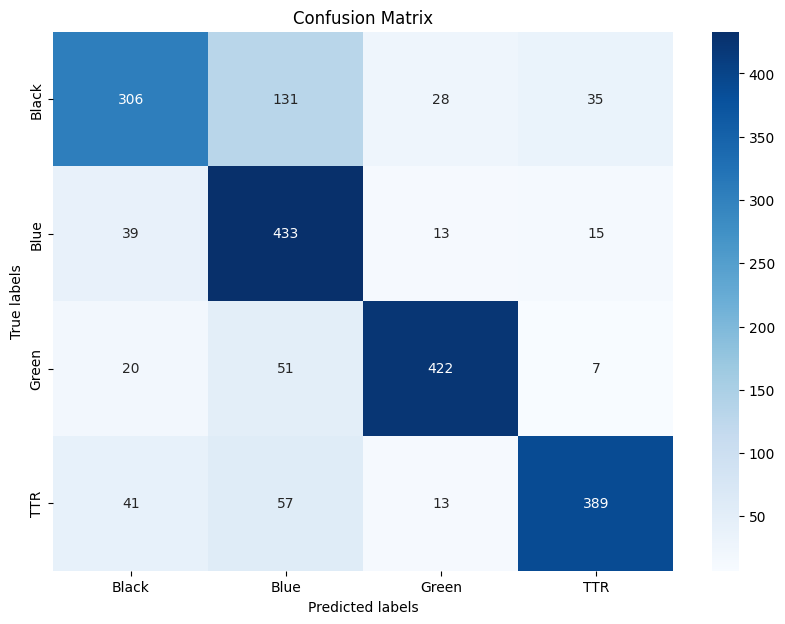

Accuracy of Black: 61.20%
Accuracy of Blue: 86.60%
Accuracy of Green: 84.40%
Accuracy of TTR: 77.80%
Accuracy of the untuned model on the test images: 77.50%
Evaluation of tuned model using Test Set:



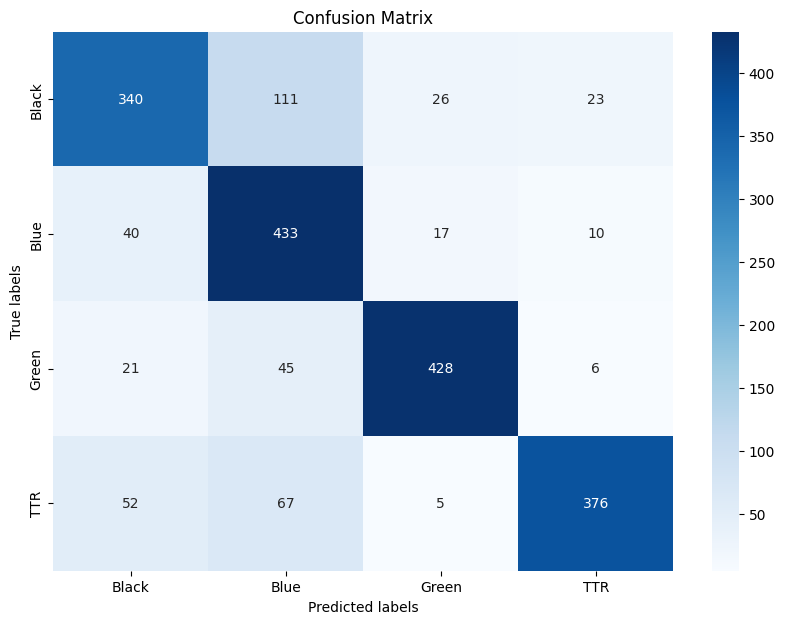

Accuracy of Black: 68.00%
Accuracy of Blue: 86.60%
Accuracy of Green: 85.60%
Accuracy of TTR: 75.20%
Accuracy of the tuned model on the test images: 78.85%


In [27]:
# Load the model weights and evaluate
print("Evaluation of untuned model using Test Set:\n")
model.load_state_dict(torch.load('./resnet_model/model_epoch_final.pth'))
print(f'Accuracy of the untuned model on the test images: {evaluate_model(model, test_loader, class_names):.2f}%')

print("Evaluation of tuned model using Test Set:\n")
model.load_state_dict(torch.load('./resnet_model/model_fine_tuned.pth'))
print(f'Accuracy of the tuned model on the test images: {evaluate_model(model, test_loader, class_names):.2f}%')

We have achieved a marginal test accuracy increase by unfreezing a layer in ResNet. The tuned model is overfitted.

### Conclusions:

The model was initially trained only on the final layer, exhibited a steady decrease in training loss coupled with a gradual increase in accuracy, signifying effective learning. The plateauing of accuracy after the 5th epoch indicates that the initially frozen layers of the pre-trained model were well-suited for feature extraction, with the new final layer adapting to classify the four target classes successfully. The final accuracy of 77.50% demonstrates the model's capability to generalize, although there is room for improvement.

The model's fine-tuning involved unfreezing the last block (layer4) and the fully connected layer (fc), enabling them to be trained with the rest of the network. This step aimed to refine the feature representations for the specific task further. The optimizer's learning rate adjustment for the newly unfrozen layers ensured that the pre-existing knowledge captured by the network was not dramatically altered. Continued training for an additional 10 epochs resulted in a marginally better model. The accuracy per class increased, most notably for the 'Black' category, which saw a 6.8% rise, while 'Green' also saw a slight increase. However, 'TTR' experienced a minor drop in accuracy, which indicates that some overfitting may have occurred for this class. The overall accuracy increased minimally to 78.85%.